# Modèle : SVM

In [1]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.svm import SVR
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("../scripts/")

# librairies perso
from import_data import import_data
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure, permutation_feature_importance
from model_objet import Model

In [2]:
data = import_data()

def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/gasNat.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 37, 38 , 49]))]

In [25]:
Model1 = Model(data, ["forecasted_consumption", "CAC"], ["real_consumption"],0.8, True, "Linear")
Model1.generate_train_set()

# 1. Création du modèle SVM régresseur
svm_regressor = SVR(kernel='linear')  # Choisissez le noyau approprié ('linear', 'rbf', 'poly', etc.)

# 2. Entraînement du modèle
i = 7
svm_regressor.fit(Model1.x_train[i], np.array(Model1.y_train[i]).ravel())  # X_train est votre ensemble d'entraînement des variables indépendantes, y_train est l'ensemble d'entraînement des variables dépendantes (valeurs cibles)

# 3. Prédiction avec le modèle entraîné
Model1.y_pred = svm_regressor.predict(Model1.x_test[i])  # X_test est votre ensemble de données de test des variables indépendantes

In [26]:
time = data.groupby("id_client").get_group(i)["horodate"]
time = time[time > Model1.date_lim]

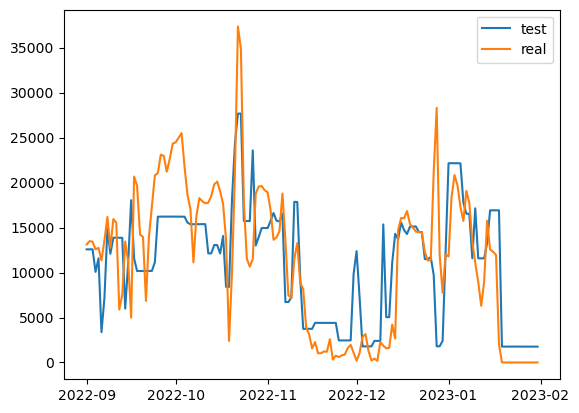

In [27]:
plt.plot(time, Model1.y_pred, label = "test")
plt.plot(time, Model1.y_test[i], label ="real")
plt.legend()